In [ ]:
import numpy as np
import pickle
import pandas as pd


In [ ]:
file_path = "/content/drive/MyDrive/Thesis/processed_eeg_data.pkl"
with open(file_path, "rb") as f:
    eeg_data = pickle.load(f)



In [ ]:
# Access the NumPy array within the dictionary using the 'data' key
data = eeg_data['data']
print(data.shape)

(64, 3, 3, 54, 26000)


In [ ]:
print(np.isnan(data).any())

True


In [ ]:
print(np.isnan(data).sum())


619211396


In [ ]:
import numpy as np
from scipy import interpolate

def clean_trials(eeg_data, max_nan_ratio=0.3, interpolate_threshold=0.1):

    n_subjects, n_conditions, n_subconditions, n_trials, n_times = data.shape
    cleaned_data = []  # List of subjects

    for subj_idx in range(n_subjects):
        subj_clean = []

        for cond_idx in range(n_conditions):
            cond_clean = []

            for subcond_idx in range(n_subconditions):
                valid_trials = []

                for trial_idx in range(n_trials):
                    trial = eeg_data[subj_idx, cond_idx, subcond_idx, trial_idx]

                    nan_ratio = np.isnan(trial).sum() / trial.size

                    if nan_ratio == 0:
                        # No NaNs
                        valid_trials.append(trial)
                    elif nan_ratio <= interpolate_threshold:
                        # Few NaNs → interpolate
                        trial_interpolated = interpolate_nans(trial)
                        valid_trials.append(trial_interpolated)
                    elif nan_ratio <= max_nan_ratio:
                        # Moderate NaNs → maybe interpolate, or ignore based on need
                        trial_interpolated = interpolate_nans(trial)
                        valid_trials.append(trial_interpolated)
                    else:
                        # Too many NaNs → drop this trial
                        continue

                cond_clean.append(np.array(valid_trials))
            subj_clean.append(cond_clean)
        cleaned_data.append(subj_clean)

    return cleaned_data

def interpolate_nans(signal):
    """Simple linear interpolation over NaNs."""
    nans = np.isnan(signal)
    if nans.any():
        x = np.arange(len(signal))
        signal[nans] = np.interp(x[nans], x[~nans], signal[~nans])
    return signal


In [ ]:
# Assuming you loaded eeg_data from the pickle
cleaned_eeg = clean_trials(data)

print("Cleaning done!")

Cleaning done!


In [ ]:
# Initialize counters
total_subjects = len(cleaned_eeg)
total_trials = 0
signal_length = None

for subject in cleaned_eeg:
    for condition in subject:
        for subcondition in condition:
            total_trials += len(subcondition)
            if len(subcondition) > 0 and signal_length is None:
                signal_length = subcondition[0].shape[0]  # should be 26000

# Final
print(f"Final cleaned data shape: ({total_trials}, {signal_length})")

Final cleaned data shape: (6229, 26000)


In [ ]:
import pickle
import numpy as np
import pandas as pd

# ... (previous code for loading and cleaning data) ...

# Create a list to store the data along with labels
all_trials = []

for subject_idx in range(len(cleaned_eeg)):
    for condition_idx in range(len(cleaned_eeg[subject_idx])):
        for subcondition_idx in range(len(cleaned_eeg[subject_idx][condition_idx])):
            for trial in cleaned_eeg[subject_idx][condition_idx][subcondition_idx]:
                all_trials.append({
                    'subject': subject_idx,
                    'condition': condition_idx,
                    'subcondition': subcondition_idx,
                    'data': trial
                })

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(all_trials)

# Save the DataFrame to a pickle file
output_pickle_path = "/content/drive/MyDrive/Thesis/cleaned_eeg_data.pkl"  # change path if needed
with open(output_pickle_path, "wb") as f:
    pickle.dump(df, f)

print(f"✅ Cleaned EEG data with labels saved to {output_pickle_path}")

✅ Cleaned EEG data with labels saved to /content/drive/MyDrive/Thesis/cleaned_eeg_data.pkl


In [ ]:
print(df.shape)

(6229, 4)


### NEW

In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113659 sha256=3963a9c24cfe0748c5b23314c1e423c98c5e272b61d94dcba7eeceb78ea68573
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
# =====================================
# EEG Classifier (Catch22 features + RF/SVM/XGBoost)
# Memory Classifier: Five vs Nine vs Thirteen
# Binary Classifier: JustListen vs Memory
# =====================================

import numpy as np
import pickle
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
from tqdm import tqdm
from scipy.signal import resample
from pycatch22 import catch22_all

warnings.filterwarnings("ignore")
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# === Load EEG data ===
with open("/content/drive/MyDrive/Thesis/processed_eeg_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

data = data_dict["data"]  # EEG: Shape (65, 3, 3, 54, 26000)

print(f"✅ EEG data shape: {data.shape}")

# === Utility functions ===
def clean_signals(X):
    X = np.nan_to_num(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

def downsample_signals(X, target_len=6000):
    return np.array([resample(sig, target_len) for sig in X])

def extract_features(X_signals):
    return np.array([catch22_all(sig)["values"] for sig in tqdm(X_signals, desc="🔍 Extracting Catch22")])

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_roc_auc(y_true, y_prob, n_classes, title="ROC Curve"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

✅ EEG data shape: (64, 3, 3, 54, 26000)


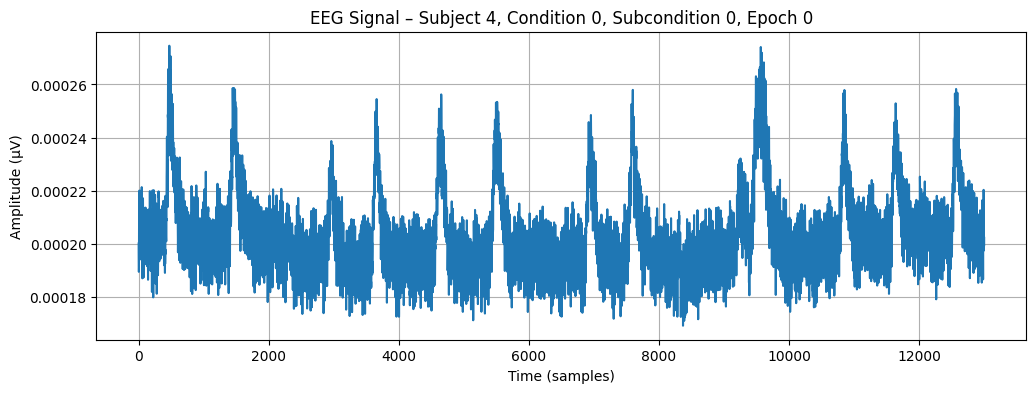

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select indices
subject_idx = 3
condition_idx = 0
subcondition_idx = 0

# Extract all 54 epochs for the selected trial condition
epochs = data[subject_idx, condition_idx, subcondition_idx]  # Shape: (54, 26000)

# 1. Plot a single EEG epoch
plt.figure(figsize=(12, 4))
plt.plot(epochs[0])
plt.title("EEG Signal – Subject 4, Condition 0, Subcondition 0, Epoch 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()


In [ ]:
def train_classifier(X, y, label_names, model, model_name, is_binary=False):
    print(f"\n⚙️ Training classifier: {model_name}")

    # Fix y labels to be 1D
    y = np.array(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Cross-Validation
    print("\n🔎 Performing 5-Fold Cross-Validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="accuracy")
    print(f"✅ Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    start_time = time.time()

    model.fit(X_train_res, y_train_res)

    end_time = time.time()
    print(f"⏱️ Training Time: {end_time - start_time:.2f} seconds")

    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred).ravel()   # Flatten prediction

    y_proba = model.predict_proba(X_test)

    # Now everything is clean 1D for metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Test Accuracy: {acc:.4f}")
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_names))

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, labels=label_names, title=f"{model_name} - Confusion Matrix")

    # ROC
    if is_binary:
        if y_proba.shape[1] == 2:
            positive_class_probs = y_proba[:, 1]
        else:
            positive_class_probs = y_proba.ravel()  # in case it's weirdly shaped

        roc_auc = roc_auc_score(y_test, positive_class_probs)
        fpr, tpr, _ = roc_curve(y_test, positive_class_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()
    else:
        plot_roc_auc(y_test, y_proba, n_classes=len(label_names), title=f"{model_name} - ROC Curve")


    # Feature Importance
    if isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [f"Feature {i}" for i in indices], rotation=45)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    elif isinstance(model, XGBClassifier):
        plt.figure(figsize=(10, 6))
        plot_importance(model, max_num_features=10)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    # Save model
    dump(model, f"{model_name}.joblib")
    print(f"✅ Model saved as '{model_name}.joblib'")

📉 Normalizing and downsampling EEG memory signals...
✅ Shape after downsampling - EEG X_mem: (6564, 6000)

🔄 Extracting Catch22 features for EEG memory classifier...


🔍 Extracting Catch22: 100%|██████████| 6564/6564 [09:05<00:00, 12.03it/s]



⚙️ Training classifier: EEG_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9975 ± 0.0013
⏱️ Training Time: 1.75 seconds

✅ Test Accuracy: 0.9945

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      1.00      1.00       582
    Nine-Memory       1.00      0.98      0.99       552
Thirteen-Memory       0.98      1.00      0.99       507

       accuracy                           0.99      1641
      macro avg       0.99      0.99      0.99      1641
   weighted avg       0.99      0.99      0.99      1641



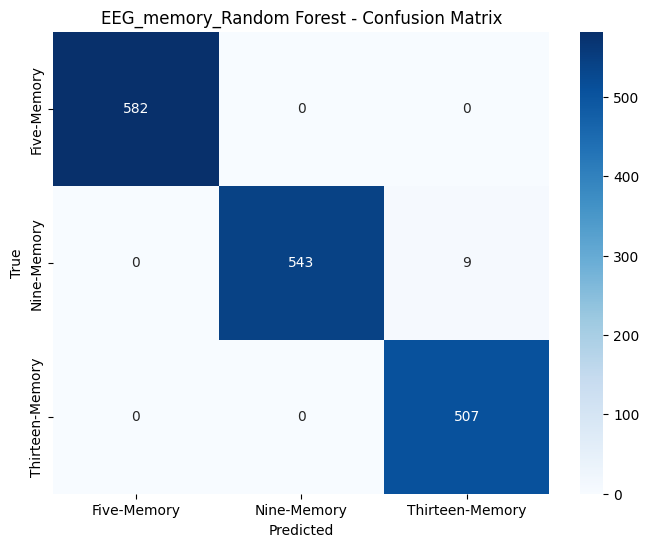

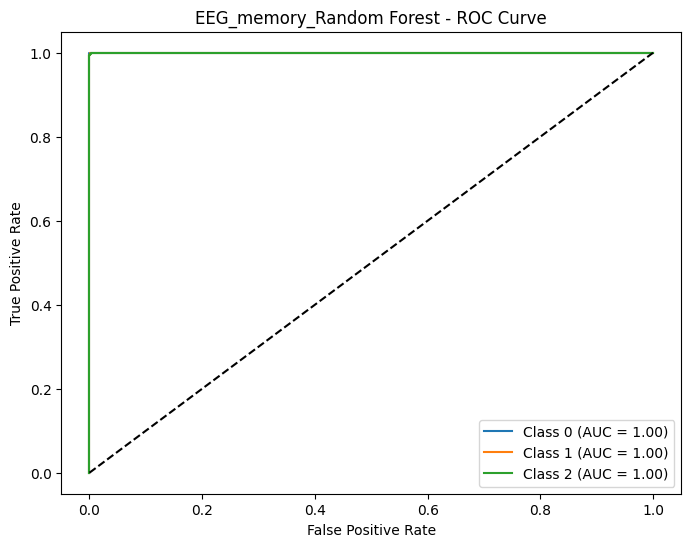

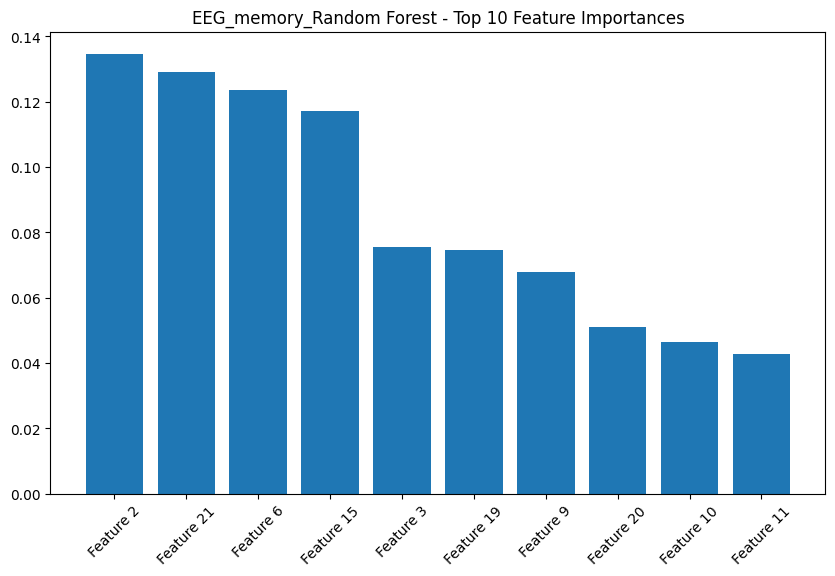

✅ Model saved as 'EEG_memory_Random Forest.joblib'

⚙️ Training classifier: EEG_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9840 ± 0.0059
⏱️ Training Time: 0.44 seconds

✅ Test Accuracy: 0.9799

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.99      1.00      0.99       582
    Nine-Memory       1.00      0.95      0.97       552
Thirteen-Memory       0.95      0.99      0.97       507

       accuracy                           0.98      1641
      macro avg       0.98      0.98      0.98      1641
   weighted avg       0.98      0.98      0.98      1641



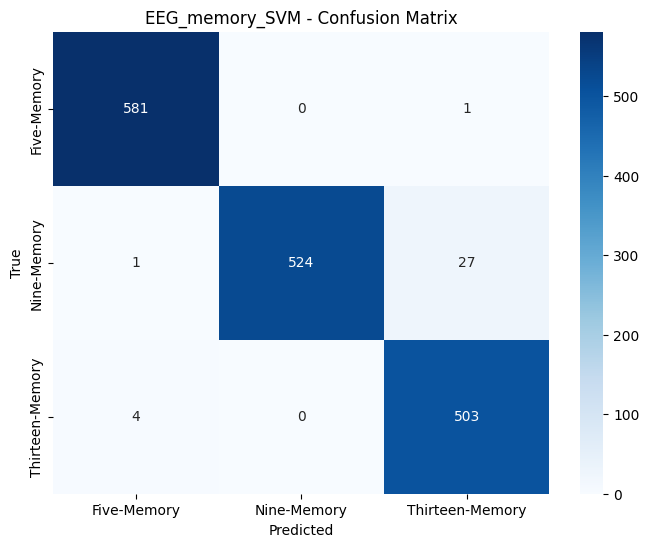

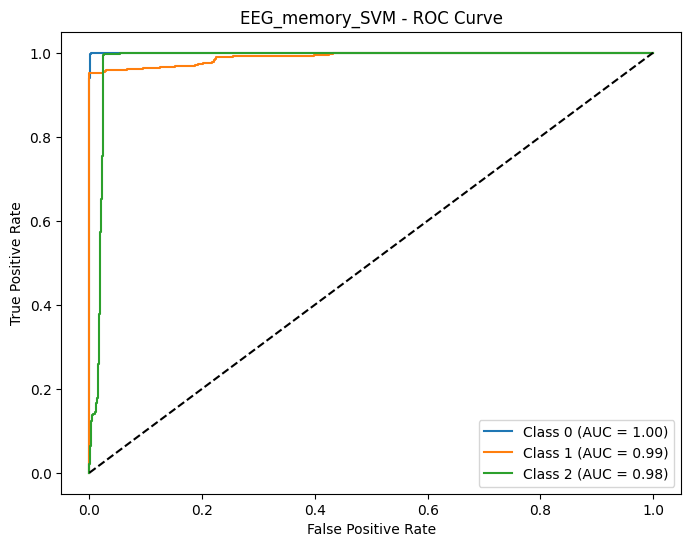

✅ Model saved as 'EEG_memory_SVM.joblib'

⚙️ Training classifier: EEG_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9977 ± 0.0010
⏱️ Training Time: 0.95 seconds

✅ Test Accuracy: 0.9982

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      1.00      1.00       582
    Nine-Memory       1.00      1.00      1.00       552
Thirteen-Memory       1.00      1.00      1.00       507

       accuracy                           1.00      1641
      macro avg       1.00      1.00      1.00      1641
   weighted avg       1.00      1.00      1.00      1641



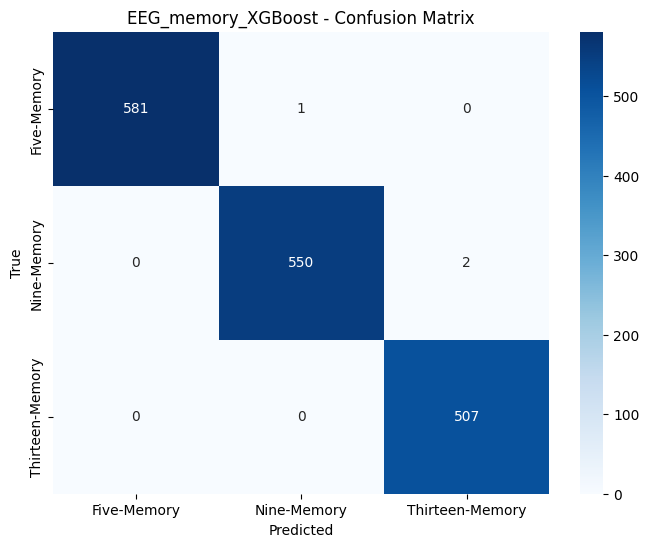

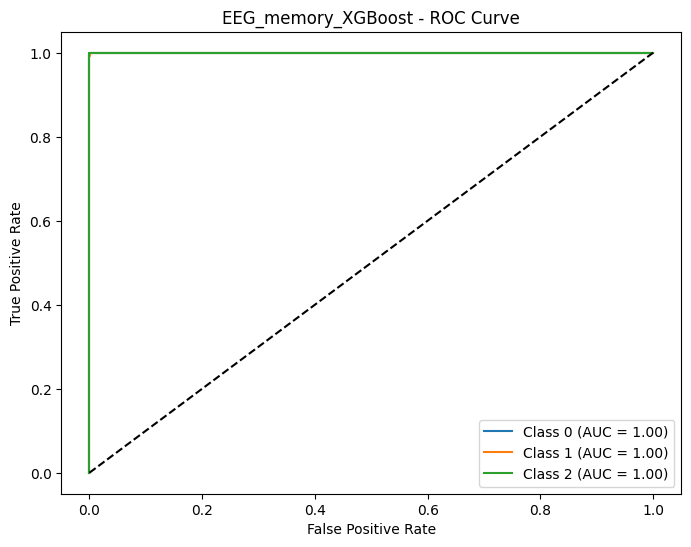

<Figure size 1000x600 with 0 Axes>

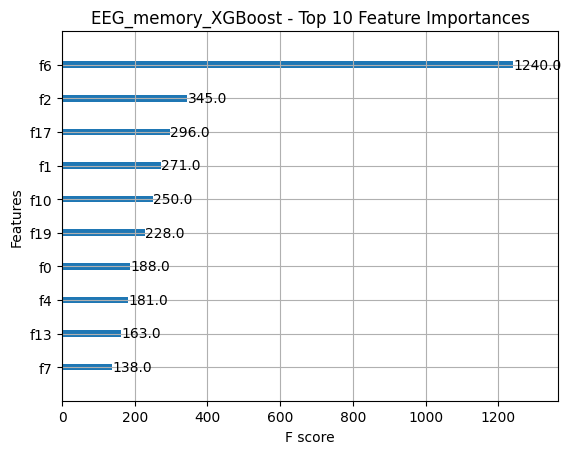

✅ Model saved as 'EEG_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for Memory Classifier (EEG) ===
X_mem, y_mem = [], []
memory_label_map = {
    "Five-Memory": 0,
    "Nine-Memory": 1,
    "Thirteen-Memory": 2
}

for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in [1, 2]:  # Memory Correct, Memory Incorrect
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = f"{condition}-Memory"
                    X_mem.append(signal)
                    y_mem.append(memory_label_map[label])

X_mem = np.array(X_mem)
print("📉 Normalizing and downsampling EEG memory signals...")
X_mem = clean_signals(X_mem)
X_mem = downsample_signals(X_mem, target_len=6000)  # EEG: Downsample to 2000
print("✅ Shape after downsampling - EEG X_mem:", X_mem.shape)

print("\n🔄 Extracting Catch22 features for EEG memory classifier...")
X_mem_features = extract_features(X_mem)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        objective="multi:softprob", num_class=3, random_state=42, n_jobs=-1
    ),
}

# === Train models for EEG memory classification ===
for model_name, model in models.items():
    train_classifier(X_mem_features, np.array(y_mem), list(memory_label_map.keys()), model, f"EEG_memory_{model_name}", is_binary=False)

## JUST LISTEN VS MEMORY


📉 Normalizing and downsampling EEG binary signals...
✅ Shape after downsampling - EEG X_jm: (9593, 6000)

🔄 Extracting Catch22 features for EEG binary classifier...


🔍 Extracting Catch22: 100%|██████████| 9593/9593 [13:29<00:00, 11.86it/s]



⚙️ Training classifier: EEG_justlisten_vs_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6156 ± 0.0101
⏱️ Training Time: 8.75 seconds

✅ Test Accuracy: 0.5657

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.30      0.28      0.29       757
      Memory       0.68      0.70      0.69      1642

    accuracy                           0.57      2399
   macro avg       0.49      0.49      0.49      2399
weighted avg       0.56      0.57      0.56      2399



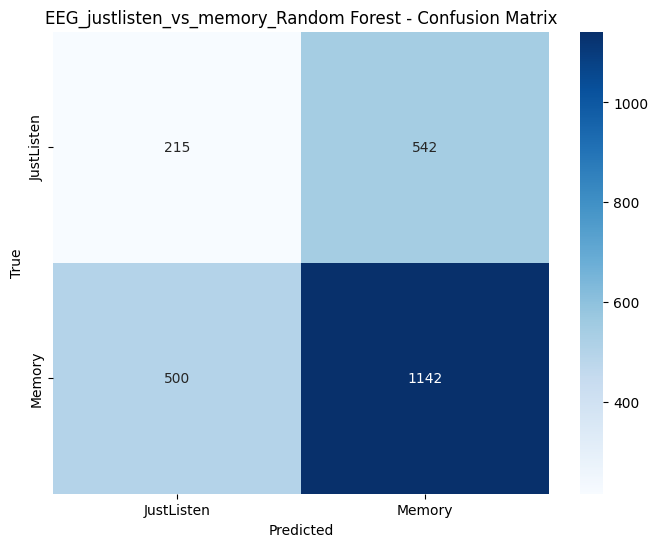

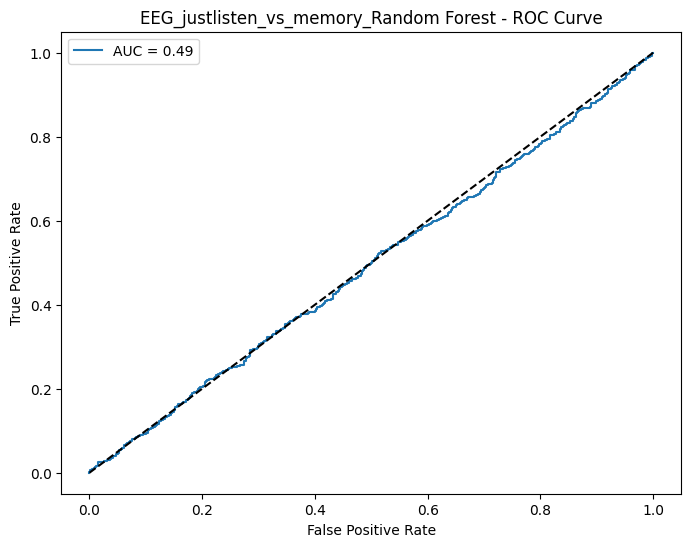

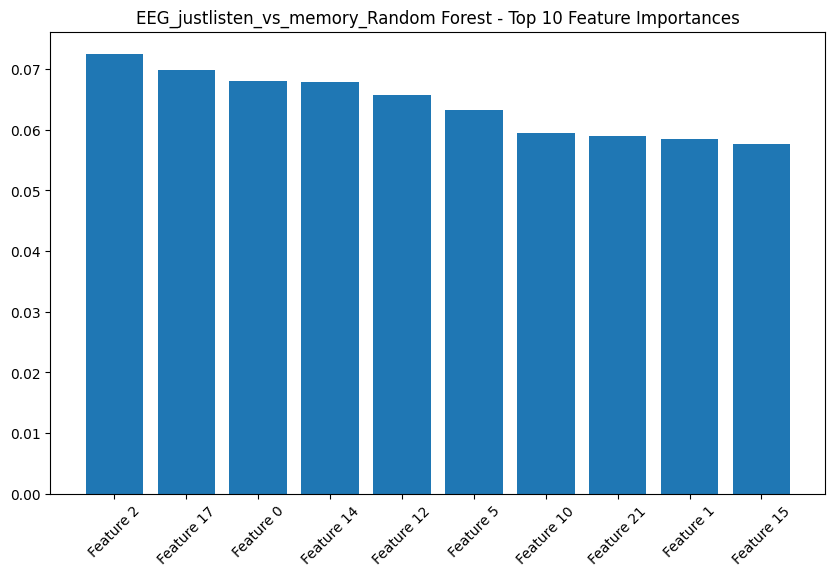

✅ Model saved as 'EEG_justlisten_vs_memory_Random Forest.joblib'

⚙️ Training classifier: EEG_justlisten_vs_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.5035 ± 0.0072
⏱️ Training Time: 41.00 seconds

✅ Test Accuracy: 0.4860

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.52      0.39       757
      Memory       0.68      0.47      0.56      1642

    accuracy                           0.49      2399
   macro avg       0.49      0.49      0.47      2399
weighted avg       0.56      0.49      0.50      2399



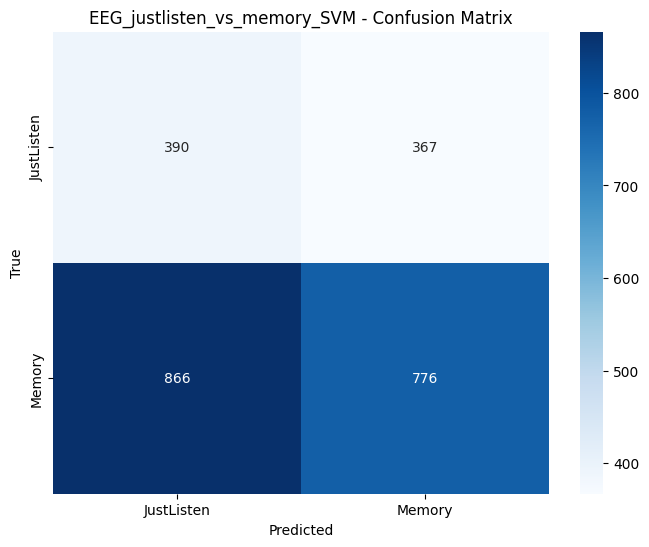

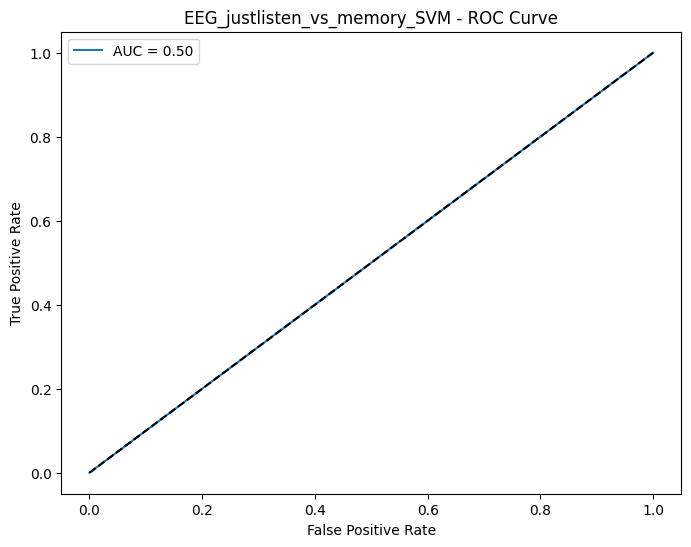

✅ Model saved as 'EEG_justlisten_vs_memory_SVM.joblib'

⚙️ Training classifier: EEG_justlisten_vs_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7230 ± 0.0076
⏱️ Training Time: 1.57 seconds

✅ Test Accuracy: 0.5732

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.29      0.30       757
      Memory       0.68      0.70      0.69      1642

    accuracy                           0.57      2399
   macro avg       0.50      0.50      0.50      2399
weighted avg       0.57      0.57      0.57      2399



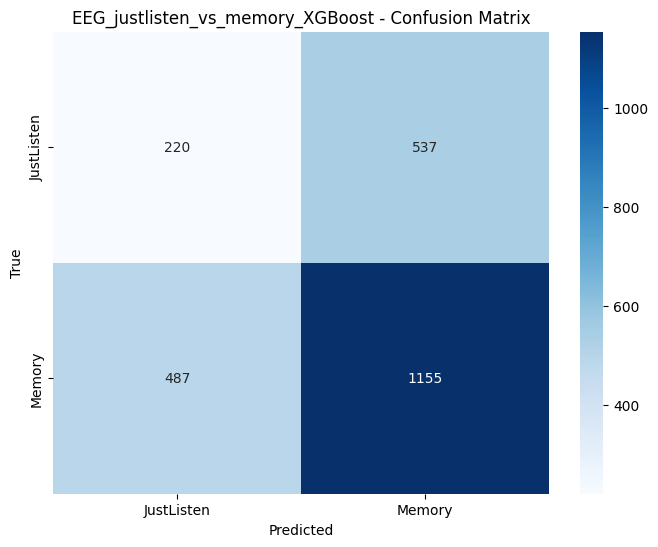

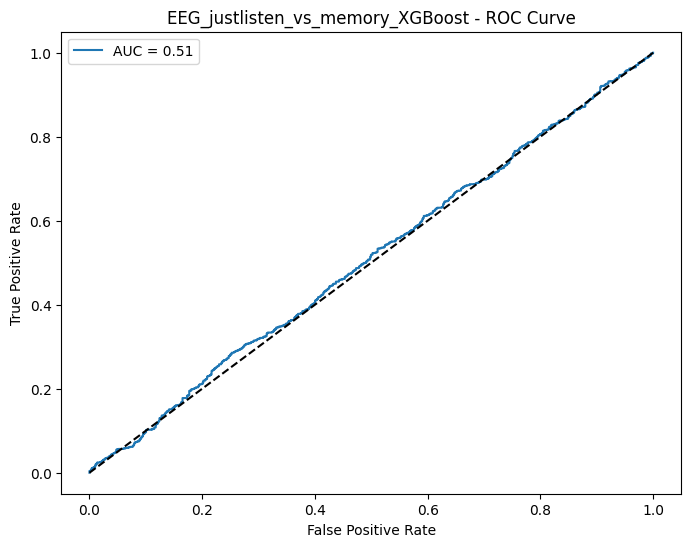

<Figure size 1000x600 with 0 Axes>

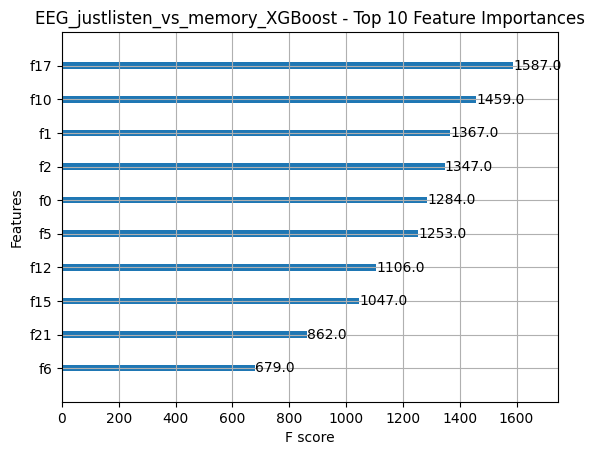

✅ Model saved as 'EEG_justlisten_vs_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for JustListen vs Memory Classifier (EEG) ===
X_jm, y_jm = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in range(3):  # JustListen = 0, Memory Correct = 1, Memory Incorrect = 2
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = 0 if subcond_idx == 0 else 1  # 0: JustListen, 1: Memory (either correct/incorrect)
                    X_jm.append(signal)
                    y_jm.append(label)

X_jm = np.array(X_jm)
print("\n📉 Normalizing and downsampling EEG binary signals...")
X_jm = clean_signals(X_jm)
X_jm = downsample_signals(X_jm, target_len=6000)
print("✅ Shape after downsampling - EEG X_jm:", X_jm.shape)

print("\n🔄 Extracting Catch22 features for EEG binary classifier...")
X_jm_features = extract_features(X_jm)

# === Models for JustListen vs Memory Classifier ===
binary_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        objective="binary:logistic", random_state=42, n_jobs=-1
    ),
}

# === Train models for EEG binary classification ===
for model_name, model in binary_models.items():
    train_classifier(X_jm_features, np.array(y_jm), ["JustListen", "Memory"], model, f"EEG_justlisten_vs_memory_{model_name}", is_binary=True)

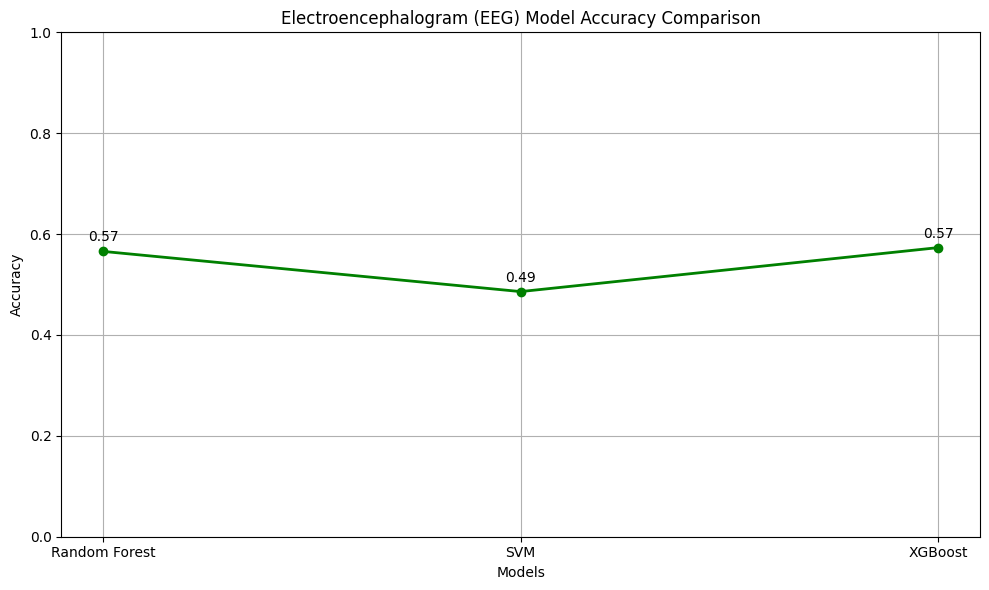

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['Random Forest', 'SVM', 'XGBoost']

# Corresponding accuracies (replace with your actual values if needed)
accuracies = [0.5657, 0.4860, 0.5732]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', linestyle='-', color='green', linewidth=2)

plt.title('Electroencephalogram (EEG) Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add data labels
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()
